In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [2]:
x = np.arange(0, 100 , 0.1)
y = 0.5*np.sin(2*x) - np.cos(x/2.0)

seq_data = y.reshape(-1, 1)
print(seq_data.shape)
print(seq_data[:5])

(1000, 1)
[[-1.        ]
 [-0.89941559]
 [-0.80029499]
 [-0.70644984]
 [-0.62138853]]


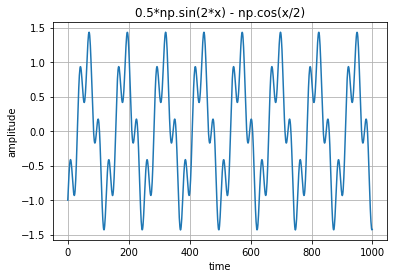

In [3]:
plt.grid()
plt.title('0.5*np.sin(2*x) - np.cos(x/2)')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(seq_data)

In [4]:
def seq2dataset(seq, window, horizon):
  X=[]
  Y=[]
  for i in range(len(seq)-(window+horizon)+1):
    x=seq[i:(i+window)]
    y=(seq[i+window+horizon-1])

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [5]:
w= 20 # window size
h = 1 # horizon factor
X, Y = seq2dataset(seq_data, w, h)
print(X.shape, Y.shape)

(980, 20, 1) (980, 1)


In [6]:
split_ratio = 0.8
split = int(split_ratio*len(X))

x_train = X[0:split]
y_train = Y[0:split]
x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 20, 1) (784, 1) (196, 20, 1) (196, 1)


In [7]:
model = Sequential()
model.add(SimpleRNN(units=128,
                    activation='tanh',
                    input_shape=x_train[0].shape))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='mse',
              metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          batch_size=16, 
          epochs=100, 
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/100
49/49 [==============================] - 1s 8ms/step - loss: 0.0709 - mae: 0.1469 - val_loss: 0.0016 - val_mae: 0.0347
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 5.4061e-04 - val_mae: 0.0187
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 5.4825e-04 - mae: 0.0186 - val_loss: 3.8718e-04 - val_mae: 0.0158
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 3.2749e-04 - mae: 0.0141 - val_loss: 1.6134e-04 - val_mae: 0.0101
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 1.8914e-04 - mae: 0.0109 - val_loss: 1.0401e-04 - val_mae: 0.0079
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 1.3711e-04 - mae: 0.0092 - val_loss: 3.2624e-04 - val_mae: 0.0147
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 1.2168e-04 - mae: 0.0085 - val_loss: 1.1974e-04 - val_mae: 0.0087
Epoch 8/100
49/49 [====================

7/7 [==============================] - 0s 2ms/step
0.010538665218734294


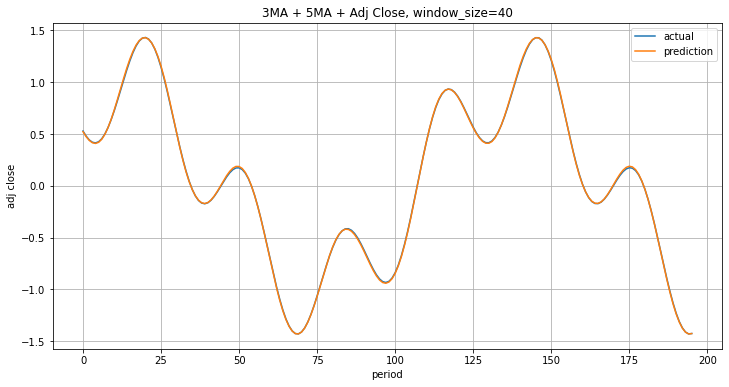

In [9]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

# 평균절대값백분율오차계산(MAPE)
print(np.sum(abs(y_test-pred)/y_test)/len(x_test))

In [10]:
rand_idx = np.random.randint(0, len(y_test), size=5)
print('rando idx =', rand_idx, '\n')
print('pred =', pred.flatten()[rand_idx])
print('label =', y_test.flatten()[rand_idx])

rando idx = [135  86 182  10  42] 

pred = [ 0.66922957 -0.43978664 -0.2417186   0.7308004  -0.10124388]
label = [ 0.6645118  -0.43017063 -0.23920114  0.72333162 -0.10441169]


In [11]:
from datetime import datetime

start_time = datetime.now()

# 손실함수가 5 epochs을 진행을 검사하여 더이상 줄어들지 않으면 종료
# EarlyStopping(모니터링 값, 대기 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 학습 중인 모델을 자동 저장
model_checkpoint = ModelCheckpoint(filepath='bast.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

end_time = datetime.now()
print(end_time-start_time)

Epoch 1/50
19/25 [=====================>........] - ETA: 0s - loss: 3.4046e-05 - mae: 0.0047
Epoch 1: val_loss improved from inf to 0.00002, saving model to bast.h5
25/25 [==============================] - 0s 6ms/step - loss: 3.2122e-05 - mae: 0.0045 - val_loss: 1.8266e-05 - val_mae: 0.0035
Epoch 2/50
19/25 [=====================>........] - ETA: 0s - loss: 2.0244e-05 - mae: 0.0035
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to bast.h5
25/25 [==============================] - 0s 5ms/step - loss: 1.9932e-05 - mae: 0.0035 - val_loss: 1.4900e-05 - val_mae: 0.0030
Epoch 3/50
19/25 [=====================>........] - ETA: 0s - loss: 1.8636e-05 - mae: 0.0033
Epoch 3: val_loss did not improve from 0.00001
25/25 [==============================] - 0s 4ms/step - loss: 2.0521e-05 - mae: 0.0035 - val_loss: 1.7548e-05 - val_mae: 0.0032
Epoch 4/50
19/25 [=====================>........] - ETA: 0s - loss: 1.7893e-05 - mae: 0.0034
Epoch 4: val_loss improved from 0.00001 to 0.00001, 

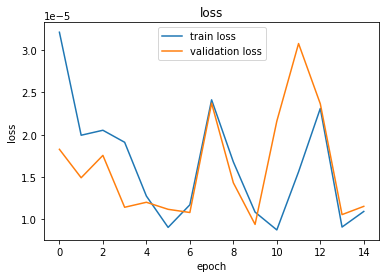

In [12]:
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')